# 모델 로드 하기

## 라이브러리

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.style.use('seaborn')
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

In [47]:
#!pip install -q langchain pypdf sentence-transformers chromadb openai

## LLM모델 및 tokenizer 불러 오기

In [48]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

- [The Open Ko-LLM Leaderboard](https://huggingface.co/spaces/upstage/open-ko-llm-leaderboard)
- kyujinpy/Ko-PlatYi-6B 

In [2]:
model_id = "kyujinpy/Ko-PlatYi-6B"
model = AutoModelForCausalLM.from_pretrained(
        model_id,
        return_dict=True,
        torch_dtype=torch.float16,
        device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


- GAI-LLM/Yi-Ko-6B-dpo-v6 (로딩은 되는데 실 사용시 메모리 부족)

In [4]:
# model_id = "GAI-LLM/Yi-Ko-6B-dpo-v6"
# model = AutoModelForCausalLM.from_pretrained(
#         model_id,
#         return_dict=True,
#         torch_dtype=torch.float16,
#         device_map='auto'
# )
# tokenizer = AutoTokenizer.from_pretrained(model_id)

- megastudyedu/M-SOLAR-10.7B-v1.1-beta (로딩은 되는데 실 사용시 메모리 부족)

In [3]:
# model_id = "megastudyedu/M-SOLAR-10.7B-v1.1-beta"
# model = AutoModelForCausalLM.from_pretrained(
#         model_id,
#         return_dict=True,
#         torch_dtype=torch.float16,
#         device_map='auto'
# )
# tokenizer = AutoTokenizer.from_pretrained(model_id)

## 구동 확인

In [197]:
device = "cuda:0"

messages = [
    {"role": "user", "content": "손흥민의 아버지 이름은?"}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
model_inputs = encodeds.to(device)

generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

<|startoftext|> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

손흥민의 아버지 이름은? [/INST]<|endoftext|>


# RAG

## Document Loading

In [51]:
from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders import WebBaseLoader
from tqdm import tqdm

- PyPDFLoader로 pdf 파일의 text를 불러와 page 별로 리스트 형태로 저장한다.

In [52]:
# pages = []
# name_list = ['아이유', '백종원', '김연경', '박찬호', '손흥민', '정우성', '김연아']
# for name in tqdm(name_list):
#     loader = PyPDFLoader(f"./data/{name}.pdf")
#     page = loader.load_and_split()
#     pages.extend(page)

- WebBaseLoader 로 web상의 컨텐츠를 불러 온다

In [7]:
# Load wiki post

url_list = ["https://namu.wiki/w/%EC%95%84%EC%9D%B4%EC%9C%A0", "https://namu.wiki/w/%EB%B0%B1%EC%A2%85%EC%9B%90", 
           "https://namu.wiki/w/%EA%B9%80%EC%97%B0%EA%B2%BD", "https://namu.wiki/w/%EB%B0%95%EC%B0%AC%ED%98%B8",
            "https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC", "https://namu.wiki/w/%EC%A0%95%EC%9A%B0%EC%84%B1",
            "https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84"
           ]
pages = []
for url in tqdm(url_list):
    loader = WebBaseLoader(url)
    pages.extend(loader.load())

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.14s/it]


In [8]:
len(pages)

7

## Text Splitting
- 불러온 document를 여러 chunk 로 분할 한다

### RecursiveCharacterTextSplitter

In [152]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
        separators=['\n', '\n\n', '. ', '', ' '],
        chunk_size=500, 
        chunk_overlap=50
) # token의 길이는 기본 함수 len 사용
docs = text_splitter.split_documents(pages)

In [153]:
len(docs)

1148

In [154]:
docs[0]

Document(page_content='아이유 - 나무위키  최근 변경  최근 토론  특수 기능              아이유', metadata={'source': 'https://namu.wiki/w/%EC%95%84%EC%9D%B4%EC%9C%A0', 'title': '아이유 - 나무위키', 'language': 'No language found.'})

In [159]:
docs[0].page_content

'아이유 - 나무위키  최근 변경  최근 토론  특수 기능              아이유'

In [160]:
doc_len = 0
for doc in docs:
    doc_len += len(doc.page_content)
doc_len/len(docs)    

402.4459930313589

## Embedding

- split 된 docs 를 embedding 하기 위해
- HuggingFace로 부터 한국어 SentenceTransformer model을 불러 온다.
- "jhgan/ko-sbert-nli" [소스](https://github.com/jhgan00/ko-sentence-transformers?tab=readme-ov-file)
- 위 text를 768차원의 vector로 변환해 준다
- 언어별로 model을 찾아야 한다.
- 여러 언어가 섞여 있으면 성능 저하가 올 수 있다.

In [164]:
from sentence_transformers import SentenceTransformer

model_name = "jhgan/ko-sbert-nli"
embedding_model = SentenceTransformer(model_name)

s1 = "나는 개를 좋아한다."
s2 = "나는 치와와를 좋아한다."
s3 = "한국의 요즘 날씨는 어떤가요?"
e1 = embedding_model.encode(s1)
e2 = embedding_model.encode(s2)
e3 = embedding_model.encode(s3)

print(np.dot(e1, e2))
print(np.dot(e1, e3))
print(np.dot(e2, e3))

260.74365
34.669853
35.432655


In [14]:
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "jhgan/ko-sbert-nli"
model_kwargs = {'device':device}
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

## VectorStore
- VetorStore는 document의 chunk를 임베팅/Tokenize 한 후 이를 저장하는 저장소
- 기본적으로 VectorStore는 벡터를 일시적으로 저장 
- 하나의 chunk 당 하나의 vector 할당
- 임베딩된 데이터를 인덱싱 하여 input query와의 유사도를 빠르게 출력
- text와 임베딩 모듈을 매개변수로 from_document 함수로 넘겨주면 db 생성됨
- 무료 VectorStore로는 대표적으로 Faiss와 Chroma가 대표적 

#### Chroma/Faiss

- Chroma
    - 대표적인 오픈소스 VectorStore
    - 텍스트, 오디오, 비디오 등의 비구조화된 데이터를 머신 러닝 모델이 사용할 수 있는 형태로 인코딩
    - 추천 시스템, 이미지 인식, 자연어 처리에 사용
    - API 제공, 테이블(컬랙션)생성, 문서 추가, 컬렉션 쿼리

- Faiss(Facebook AI Similarity Search)
    - Facebook AI 유사성 검색은 고밀도 벡터의 효율적인 유사성 검색 및 클러스터링을 위한 라이브러리
    - 모든 크기의 벡터 집합에서 검색하는 알고리즘이 포함되어 있음
    - 평가 및 매개변수 조정을 위한 코드도 제공

In [15]:
from langchain.vectorstores import Chroma
from langchain.vectorstores import FAISS

In [16]:
db_type = "Chroma" 
# db_type = "Faiss" 

db = None

if db_type == "Chroma":
    db = Chroma.from_documents(docs, hf)
elif db_type == "Faiss":
    db = FAISS.from_documents(docs, hf)
else:
    raise('You have wrong db type')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 디스크에 저장 및 불러오기
- VectorStore를 로컬에 저장하는 기능 을 제공한다.

In [17]:
# db_type = "Chroma" 
# # db_type = "Faiss" 

# if db_type == "Chroma":
#     db = Chroma.from_documents(docs, hf, persist_directory='./chroma_db')
# elif db_type == "Faiss":
#     db = FAISS.from_documents(docs, hf)
#     db.save_local('./faiss_db')
# else:
#     raise('You have wrong db type')

- 불러오기

In [18]:
# db_type = "Chroma" 
# # db_type = "Faiss" 

# if db_type == "Chroma":
#     db = Chroma(persist_directory='./chroma_db', embedding_function=hf)
# elif db_type == "Faiss":
#     db = FAISS.load_local("./faiss_db", hf)
# else:
#     raise('You have wrong db type')

## Retriever
- VectorStore로 만든 검색기
- search_type : VectorStore에서 사용자 질문과 연관된 chunk를 뽑아내는 방법
    - similarity
    - mmr(max_marginal_relevance_search)

In [166]:
retriever = db.as_retriever(
                            search_type="similarity",
                            search_kwargs={'k': 4}
                        )

### Seatch Type

#### similarity_search
- k 값으로 유사도가 높은 k개의 값을 받아 오도록 설정 가능

In [198]:
tmp_query = "손흥민의 아버지는 누구?"
tmp_text = db.similarity_search(tmp_query, k=3)
tmp_text

[Document(page_content='. 손흥민 "올림픽대표 차출 거부는 사실무근" [핫이슈] 손흥민 격정토로 "대표팀 차출거부? 獨 언론 인터뷰조차 안 했다"인터뷰 중에 나오는 "지난해 성인대표팀 차출과 관련해 아버지의 발언이 오해를 낳아 한바탕 소란을 겪었는데, 내가 또다시 그런 발언을 한다는 것 자체가 말이 되느냐"라는 표현을 볼 때에도 아버지의 차출 거부 때문에 런던 올림픽을 가지 못했다는 것은 사실이 아님을 확인할 수 있다.이미 올림픽 직전에 손흥민의 아버지 손웅정 씨 본인도 인터뷰를 통해 2011년 발생한 차출 거부 논란에 대해 해명을 한 바 있다.# 현실적으로 볼 때 군 문제가 선수 생활에 큰 영향을 미치는 우리나라 남자 선수들 입장에서 메달 획득 확률이 높지 않다고 해서 병역 특례의 기회를 포기한다는 것은 설득력이 매우 낮다.[170]2014 인천 아시안 게임의 경우 손흥민 본인의 의지도 강했고 대한축구협회 및 이광종 감독도 손흥민 차출을 위해 백방으로 노력했으나 소속팀 바이어 04 레버쿠젠의 반대를 꺾지', metadata={'language': 'No language found.', 'source': 'https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC', 'title': '손흥민 - 나무위키'}),
 Document(page_content='. 이에 대노한 손웅정은 아들을 불러 "국가대표팀 주장이라는 놈이 감독님이 새로 오셨는데 인사는 못 드릴망정 친구들하고 맥주나 마시고 있냐!"라며 심하게 질타를 했다는 에피소드가 있다.이러한 열린 교육 끝에, 결국 손흥민은 원주 육민관중학교 축구부에 들어가게 되었고, 곧이어 재능이 점차 만개하기 시작했다. 축구 명문 동북고등학교에 진학했으나, 약 3개월 남짓만 뛰고 중퇴했다. 이후 독일 함부르크 SV 유스팀에 1년간 유학을 하고 돌아와 2007~2009년 이광종호의 일원으로 U-17 월드컵 대표에 이름을 올리게 되었다', metadata={'language': 'N

#### mmr(max_marginal_relevance_search)
- 가장 유사한 문서 뿐만 아니라, 문서들 간의 다양성을 추구 한다.
- fetch_k : 유사성 상위 문서의 수
- k : fetch_k개의 문서 중 출력할 문서의 수
- lambda_mult : 다양성과 유사성 중 어느 쪽을 중요시 할지 (1 for minimum diversity and 0 for maximum. (Default: 0.5))

In [199]:
tmp_query = "손흥민의 아버지는 누구?"
tmp_text = db.max_marginal_relevance_search(
    tmp_query, k=3, fetch_k=10, lambda_mult=0.5)
tmp_text

[Document(page_content='. 손흥민 "올림픽대표 차출 거부는 사실무근" [핫이슈] 손흥민 격정토로 "대표팀 차출거부? 獨 언론 인터뷰조차 안 했다"인터뷰 중에 나오는 "지난해 성인대표팀 차출과 관련해 아버지의 발언이 오해를 낳아 한바탕 소란을 겪었는데, 내가 또다시 그런 발언을 한다는 것 자체가 말이 되느냐"라는 표현을 볼 때에도 아버지의 차출 거부 때문에 런던 올림픽을 가지 못했다는 것은 사실이 아님을 확인할 수 있다.이미 올림픽 직전에 손흥민의 아버지 손웅정 씨 본인도 인터뷰를 통해 2011년 발생한 차출 거부 논란에 대해 해명을 한 바 있다.# 현실적으로 볼 때 군 문제가 선수 생활에 큰 영향을 미치는 우리나라 남자 선수들 입장에서 메달 획득 확률이 높지 않다고 해서 병역 특례의 기회를 포기한다는 것은 설득력이 매우 낮다.[170]2014 인천 아시안 게임의 경우 손흥민 본인의 의지도 강했고 대한축구협회 및 이광종 감독도 손흥민 차출을 위해 백방으로 노력했으나 소속팀 바이어 04 레버쿠젠의 반대를 꺾지', metadata={'language': 'No language found.', 'source': 'https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC', 'title': '손흥민 - 나무위키'}),
 Document(page_content='. 이외에도 아시아 베스트 풋볼러 8회 수상, AFC 국제 선수상 4회 수상, AFC 아시안컵 베스트팀 등 아시아 내에서 수여하는 상들 또한 독식하고 있다.2018-19 시즌 이후 한준희 해설 위원은 차범근보다 손흥민을 아시아 역대 No.1으로 인정한다고 말했다.[64] 이 시즌에 박지성에 이어 두 번째로 챔피언스 리그 결승 무대에 오르는 한국인 선수라는 점도 높은 평가에 한몫하며, 아직 현역이기 때문에 향후 활약과 우승 유무에 따라 평가가 더 오를 것으로 보인다.2016-17 시즌부터 2021년 8월 16일까지 집계한 통계에 따르면 5대 리그에서 골 기대치 대비 

## Chain

In [200]:
from langchain.llms import HuggingFacePipeline
from transformers import pipeline

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    return_full_text=True,
    max_new_tokens=500,
)

koplatyi_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

In [170]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

prompt_template = """
### [INST]
Instruction: Answer the question based on your knowledge.

Here is context to help:

{context}

### QUESTION:
{question}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain
llm_chain = LLMChain(llm=koplatyi_llm, prompt=prompt)

In [171]:
from langchain.schema.runnable import RunnablePassthrough

retriever = db.as_retriever(
                            search_type="similarity",
                            search_kwargs={'k': 4}
                        )

rag_chain = (
 {"context": retriever, "question": RunnablePassthrough()} 
 | llm_chain
) 

In [172]:
rag_chain

{
  context: VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f17d870ca00>, search_kwargs={'k': 4}),
  question: RunnablePassthrough()
}
| LLMChain(prompt=PromptTemplate(input_variables=['context', 'question'], template='\n### [INST]\nInstruction: Answer the question based on your knowledge.\n\nHere is context to help:\n\n{context}\n\n### QUESTION:\n{question}\n\n[/INST]\n '), llm=HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7f16f9bf73d0>))

In [201]:
question = "손흥민 아버지 이름은"
result = rag_chain.invoke(question)
result

{'context': [Document(page_content='. 손흥민 "올림픽대표 차출 거부는 사실무근" [핫이슈] 손흥민 격정토로 "대표팀 차출거부? 獨 언론 인터뷰조차 안 했다"인터뷰 중에 나오는 "지난해 성인대표팀 차출과 관련해 아버지의 발언이 오해를 낳아 한바탕 소란을 겪었는데, 내가 또다시 그런 발언을 한다는 것 자체가 말이 되느냐"라는 표현을 볼 때에도 아버지의 차출 거부 때문에 런던 올림픽을 가지 못했다는 것은 사실이 아님을 확인할 수 있다.이미 올림픽 직전에 손흥민의 아버지 손웅정 씨 본인도 인터뷰를 통해 2011년 발생한 차출 거부 논란에 대해 해명을 한 바 있다.# 현실적으로 볼 때 군 문제가 선수 생활에 큰 영향을 미치는 우리나라 남자 선수들 입장에서 메달 획득 확률이 높지 않다고 해서 병역 특례의 기회를 포기한다는 것은 설득력이 매우 낮다.[170]2014 인천 아시안 게임의 경우 손흥민 본인의 의지도 강했고 대한축구협회 및 이광종 감독도 손흥민 차출을 위해 백방으로 노력했으나 소속팀 바이어 04 레버쿠젠의 반대를 꺾지', metadata={'language': 'No language found.', 'source': 'https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC', 'title': '손흥민 - 나무위키'}),
  Document(page_content='. 이에 대노한 손웅정은 아들을 불러 "국가대표팀 주장이라는 놈이 감독님이 새로 오셨는데 인사는 못 드릴망정 친구들하고 맥주나 마시고 있냐!"라며 심하게 질타를 했다는 에피소드가 있다.이러한 열린 교육 끝에, 결국 손흥민은 원주 육민관중학교 축구부에 들어가게 되었고, 곧이어 재능이 점차 만개하기 시작했다. 축구 명문 동북고등학교에 진학했으나, 약 3개월 남짓만 뛰고 중퇴했다. 이후 독일 함부르크 SV 유스팀에 1년간 유학을 하고 돌아와 2007~2009년 이광종호의 일원으로 U-17 월드컵 대표에 이름을 올리게 되었다', metadata={'

## 질문해 보기
- 손홍민의 아버지 이름은? : 손웅정
- 김연아의 첫 CF : KB국민은행
- 김연경의 키는? : 192cm
- 박찬호 고등학교? : 공주고등학교
- 박찬호가 출연한 영화 : 서울서칭
- 김연아가 졸업한 고등학교 : 수리고등학교

In [204]:
question = "김연아가 졸업한 고등학교?"
result = rag_chain.invoke(question)

for i in result['context']:
    print(f"주어진 근거: {i.page_content} \n\n출처: {i.metadata['source']} - {i.metadata['title']} \n")

print(f"\n{result['text']}")

주어진 근거: . 실제로 초등학생 중에 김연아 선수를 보고 피겨 스케이팅을 배우고 싶어하는 경우가 많으며, 김연아 선수의 팬들 중 어린 팬도 많다.[14] 연느님이라는 별명이 그녀가 한국 사회에서 가지는 위치를 잘 알려준다고 볼 수 있다. ~느님이라는 별명은 아무에게나 붙는 별명이 아니기 때문이다. 실력, 인기, 인성 중 하나라도 빠져서는 안 되며 전 세대를 아우를 수 있는 인물이어야 한다. 대표적인 느님으로는 유느님이 있다. 김연아가 여태까지 찍은 CF나 광고의 종류나 숫자도 그녀의 위치를 상징한다고 볼 수 있다. 어린 시절부터 은퇴하고 시간이 꽤 흐른 지금까지도 김연아는 최고의 CF 스타 중 한 명이다. 이렇게 그녀의 인지도나 인기는 아직도 상당하기에 김연아라는 인물의 '브랜드 가치'는 아직 매우 높다고 말할 수 있다 

출처: https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84 - 김연아 - 나무위키 

주어진 근거: . 국민적 관심도가 김연아를 계기로 그 전과는 비교할 수 없이 높아진 것에 더해, 김연아 본인 역시 잠정 은퇴 수준이었던 공백기를 끊고 다시 돌아온 이유도 '한국 피겨계를 위해 할 일이 있는 것 같아서'라고 밝힌 적이 있다. 그리고 김연아의 존재로 인해 피겨 스케이팅을 배우기 시작하는 어린이들의 숫자도 많이 늘어났다. 이들이 바로 소위 말하는 '연아 키즈' 세대로, 김연아 시대 이전에는 상상할 수도 없었을 선수 풀과 성과를 보여주고 있다. 현재도 많은 유망주 선수들이 등장하고 있다.2018 평창 동계올림픽 홍보대사 활동 이외에도 국내 피겨 스케이팅 대회에서 시상자로 나서기도 하고, 청소년 동계올림픽을 홍보하기도 하고, 빙상장 건설을 요청하기도 하는 등 한국 체육계의 빈곤한 환경을 지원하는 데 관심이 많다. 그녀의 활약 이후로 수많은 피겨 스케이팅 유망주들이 생기고 있고, 범국민적 관심도 크게 높아졌다 

출처: https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84 - 김연아 

# Retrieval 품질을 올리는 기법들

## 전체 vectorstore 내 embedding 결과 시각화

In [186]:
# !pip uninstall umap
# !pip install umap-learn

In [187]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm
import joblib
import os

In [42]:
embeddings = db.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [43]:
# def project_embeddings(embeddings, umap_transform, save_path='./umap_embeddings.pkl', load_path='./umap_embeddings.pkl'):
#     if load_path and os.path.exists(load_path):
#         umap_embeddings = joblib.load(load_path)
#     else:
#         umap_embeddings = np.empty((len(embeddings),2))
#         for i, embedding in enumerate(tqdm(embeddings)): 
#             umap_embeddings[i] = umap_transform.transform([embedding])
#         if save_path:
#             joblib.dump(umap_embeddings, save_path)
#     return umap_embeddings

In [44]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [45]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|███████████████████████████████████████| 1148/1148 [08:37<00:00,  2.22it/s]


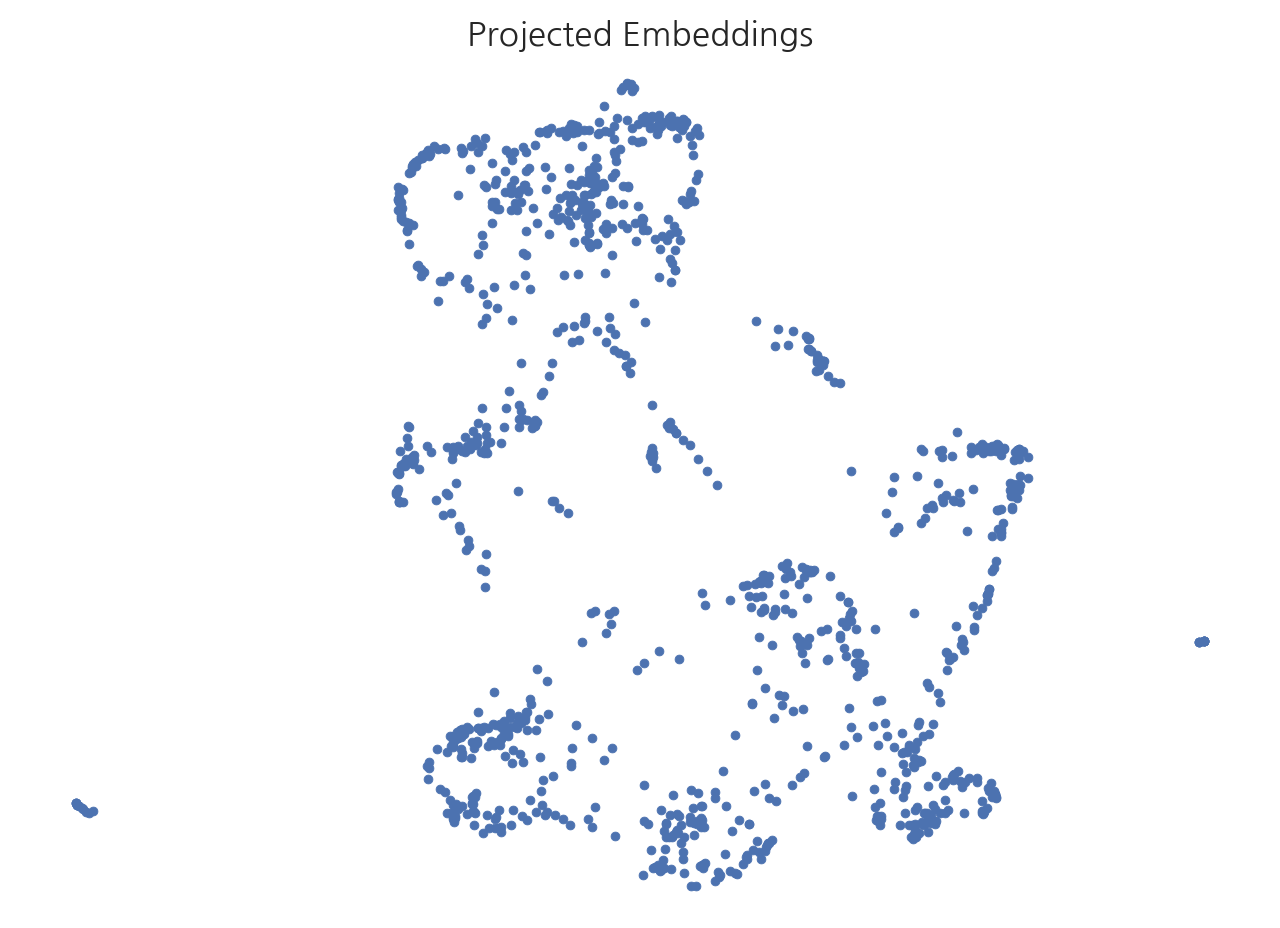

In [205]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')
plt.show()

## Multi-Query Retriver
### 사용자의 질문이 충분치 않은 경우

In [206]:
question = "김연아 졸업 고등학교?"
query_embedding = embedding_model.encode(question)

In [207]:
retrieveds = db.similarity_search(question, k=10)
retrieved_embeddings = []
for retrieved in retrieveds:
    retrieved_embeddings.append(embedding_model.encode(retrieved.page_content))

In [208]:
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.34it/s]


(-9.806482625007629, 7.074263405799866, -4.205968964099884, 7.829967367649078)

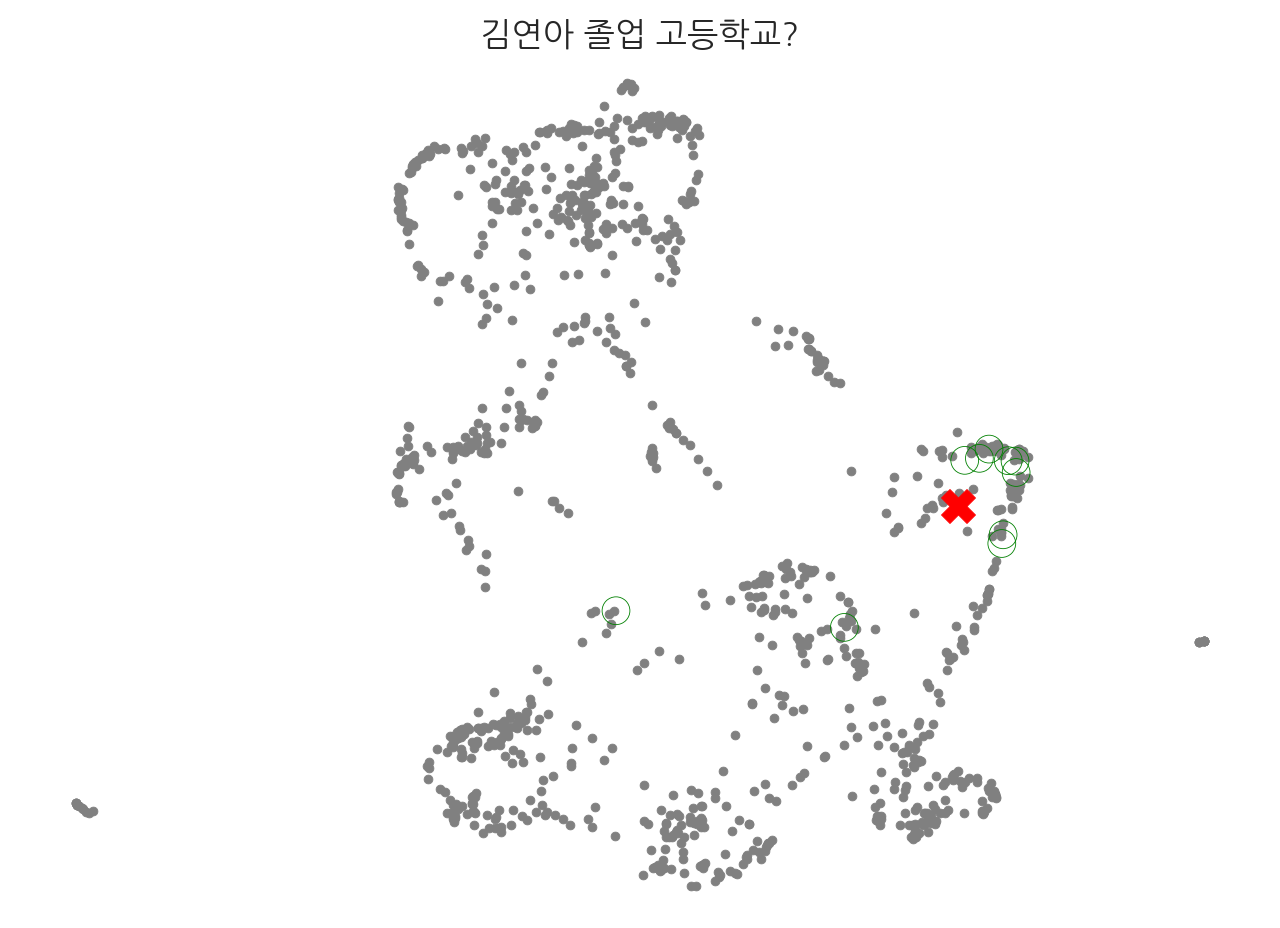

In [209]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{question}')
plt.axis('off')

In [210]:
rag_chain.invoke(question)

{'context': [Document(page_content=". 실제로 초등학생 중에 김연아 선수를 보고 피겨 스케이팅을 배우고 싶어하는 경우가 많으며, 김연아 선수의 팬들 중 어린 팬도 많다.[14] 연느님이라는 별명이 그녀가 한국 사회에서 가지는 위치를 잘 알려준다고 볼 수 있다. ~느님이라는 별명은 아무에게나 붙는 별명이 아니기 때문이다. 실력, 인기, 인성 중 하나라도 빠져서는 안 되며 전 세대를 아우를 수 있는 인물이어야 한다. 대표적인 느님으로는 유느님이 있다. 김연아가 여태까지 찍은 CF나 광고의 종류나 숫자도 그녀의 위치를 상징한다고 볼 수 있다. 어린 시절부터 은퇴하고 시간이 꽤 흐른 지금까지도 김연아는 최고의 CF 스타 중 한 명이다. 이렇게 그녀의 인지도나 인기는 아직도 상당하기에 김연아라는 인물의 '브랜드 가치'는 아직 매우 높다고 말할 수 있다", metadata={'language': 'No language found.', 'source': 'https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84', 'title': '김연아 - 나무위키'}),
  Document(page_content='. 일본에서는 언론보도 및 교양프로그램 등을 통해 마오를 "학교 생활도 열심히 하며 또래들과 해맑게 웃으며 행복하게 스케이팅을 하는 타고난 천재"로, 김연아를 "하루 종일 연습만 하면서 친구도 없는 음울한 기계"처럼 이미지 메이킹을 시도도 하며 "예술(예쁘고 밝은)의 마오 vs 기술의 연아"로 구도를 만들었단 의견도 있다.[19]이는 척박한 환경에서 천재적인 재능으로 우뚝 일어선 김연아와, 어릴 때부터 주목받으면서 전형적인 엘리트 코스를 걸어온 아사다 마오의 환경차이 덕도 있었다. 하지만, 김연아는 이미 주니어 시절부터 유명한 선수였고 아사다 마오도 알려진 만큼 가정환경이 좋지는 않았다고 한다. 요즘에는 드래곤볼의 카카로트와 베지터의 라이벌 구도로 빗대어서 표현하는 경우도 많아진 듯하다', metadata={'lang

### 추가 질문 생성 결과

In [211]:
prompt_template_2 = """
### [INST]
Instruction: 
다음 질문(### QUESTION)을 친절한 문장으로 바꿔줘.

            
### QUESTION:
{question}

[/INST]
 """
# Create prompt from prompt template
prompt_multi = PromptTemplate(
    input_variables=["question"],
    template=prompt_template_2,
)

# Create llm chain
# llm_chain_multi = LLMChain(llm=koplatyi_llm)
llm_chain_multi = LLMChain(llm=koplatyi_llm, prompt=prompt_multi)

In [212]:
prompt_template_multi = f"다음 질문과 유사한 문장을 만들어줘.질문 : {question}"
questions = llm_chain_multi.run(prompt_template_multi)
question = question + ' ' +questions 
# question =  '김연아 졸업 고등학교 , 김연아가 졸업한 고등학교는 어디인가요?'
question

'김연아 졸업 고등학교? \n질문: 김연아가 졸업한 고등학교는 어디인가요?'

- 질문과 vectorstore의 거리 시각화

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.34it/s]


(-9.806482625007629, 7.074263405799866, -4.205968964099884, 7.829967367649078)

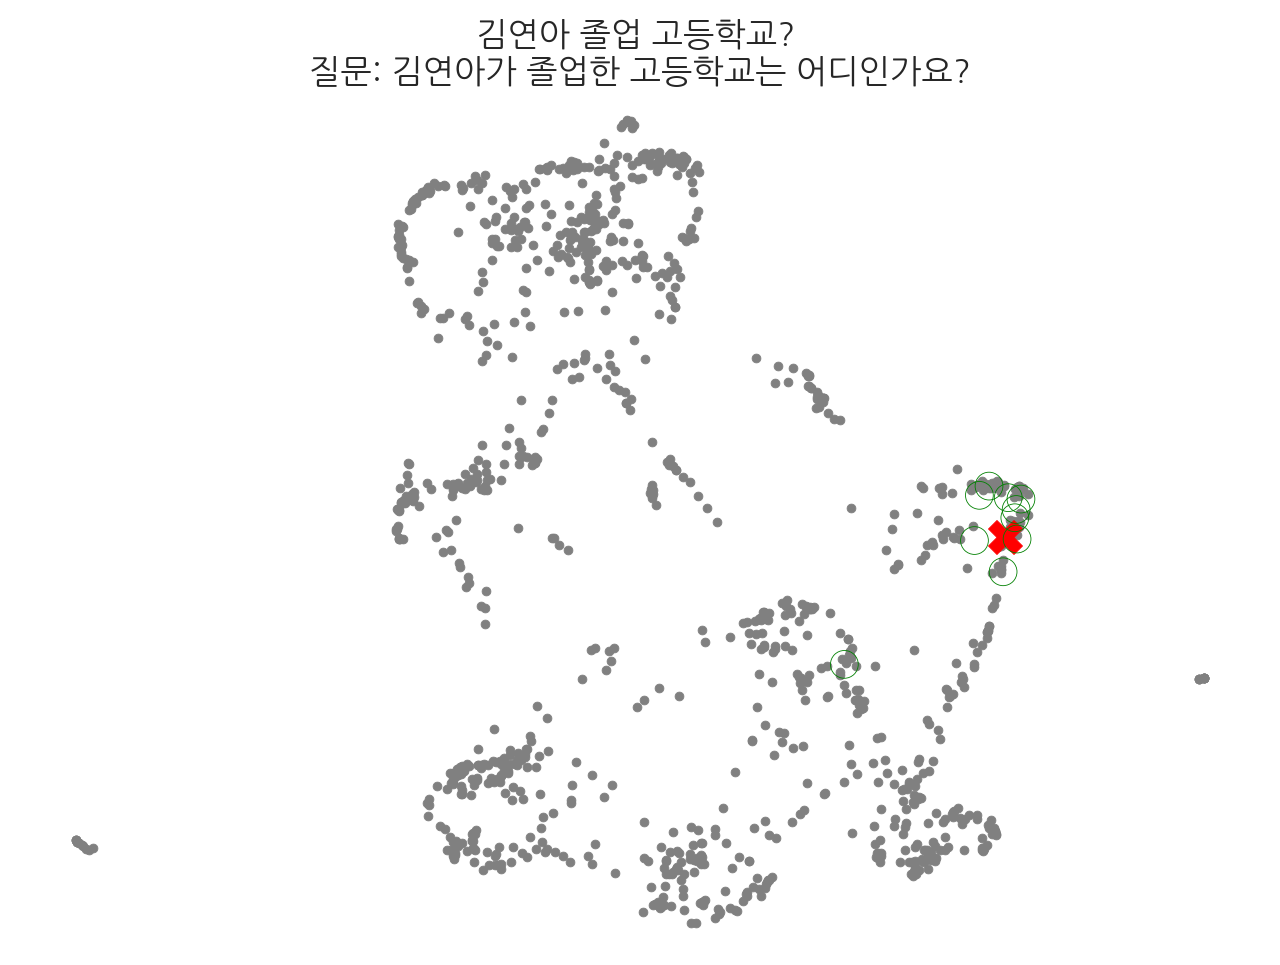

In [213]:
query_embedding = embedding_model.encode(question)

retrieveds = db.similarity_search(question, k=10)
retrieved_embeddings = []
for retrieved in retrieveds:
    retrieved_embeddings.append(embedding_model.encode(retrieved.page_content))

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{question}')
plt.axis('off')

In [214]:
rag_chain.invoke(question)

{'context': [Document(page_content=". 실제로 초등학생 중에 김연아 선수를 보고 피겨 스케이팅을 배우고 싶어하는 경우가 많으며, 김연아 선수의 팬들 중 어린 팬도 많다.[14] 연느님이라는 별명이 그녀가 한국 사회에서 가지는 위치를 잘 알려준다고 볼 수 있다. ~느님이라는 별명은 아무에게나 붙는 별명이 아니기 때문이다. 실력, 인기, 인성 중 하나라도 빠져서는 안 되며 전 세대를 아우를 수 있는 인물이어야 한다. 대표적인 느님으로는 유느님이 있다. 김연아가 여태까지 찍은 CF나 광고의 종류나 숫자도 그녀의 위치를 상징한다고 볼 수 있다. 어린 시절부터 은퇴하고 시간이 꽤 흐른 지금까지도 김연아는 최고의 CF 스타 중 한 명이다. 이렇게 그녀의 인지도나 인기는 아직도 상당하기에 김연아라는 인물의 '브랜드 가치'는 아직 매우 높다고 말할 수 있다", metadata={'language': 'No language found.', 'source': 'https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84', 'title': '김연아 - 나무위키'}),
  Document(page_content='. 해당 년도 11월에 결별 기사가 나왔다.신 도라에몽 스페셜 1화 "너와 나의 아이스 쇼" 에피소드에서 아사다 마오가 YUNA로 로컬라이징 되었다.MBTI는 ESFJ이다.[77] 이후 인터뷰에서 3번 정도 검사해봤는데 마지막에는 ISFJ가 나왔다고 한다. 상황에 따라서 E와 I만 바뀌고 뒤는 고정적이라고 한다.고등학교와 대학교 졸업식에 참석하지 못했다.네이버에 \'ㅁ연으\'라고 오타를 내도 김연아로 검색된다.8.1. 영향력[편집]다양한 분야에서 헌정을 받고 있다. 나이키[78]에서 다이아몬드와 금이 들어간 골든 자켓을 헌정받았다. 루이비통에선 트렁크를 헌정받았다. 트렁크는 2개가 만들어져 하나는 경매에 올라 그 수익금이 기부에 쓰였다. 미국에선 김연아를 위한 헌정시를 쓴 시인과, 김연아가 제목인 교향곡을 만든 작곡가

## Ensemble Retriever

In [28]:
# !pip install -q langchain pypdf sentence-transformers chromadb langchain-openai faiss-gpu --upgrade --quiet  rank_bm25 > /dev/null

In [117]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

In [130]:
# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2 # 문서 2개

faiss_vectorstore = FAISS.from_documents(docs, hf)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2}) # 문서 2개

In [142]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [143]:
rag_ensemble_chain = (
 {"context": ensemble_retriever, "question": RunnablePassthrough()} 
 | llm_chain
) 

In [150]:
question = '김연아가 나온 고등학교?'

In [148]:
rag_ensemble_chain.invoke(question)

{'context': [Document(page_content=". 실제로 초등학생 중에 김연아 선수를 보고 피겨 스케이팅을 배우고 싶어하는 경우가 많으며, 김연아 선수의 팬들 중 어린 팬도 많다.[14] 연느님이라는 별명이 그녀가 한국 사회에서 가지는 위치를 잘 알려준다고 볼 수 있다. ~느님이라는 별명은 아무에게나 붙는 별명이 아니기 때문이다. 실력, 인기, 인성 중 하나라도 빠져서는 안 되며 전 세대를 아우를 수 있는 인물이어야 한다. 대표적인 느님으로는 유느님이 있다. 김연아가 여태까지 찍은 CF나 광고의 종류나 숫자도 그녀의 위치를 상징한다고 볼 수 있다. 어린 시절부터 은퇴하고 시간이 꽤 흐른 지금까지도 김연아는 최고의 CF 스타 중 한 명이다. 이렇게 그녀의 인지도나 인기는 아직도 상당하기에 김연아라는 인물의 '브랜드 가치'는 아직 매우 높다고 말할 수 있다", metadata={'source': 'https://namu.wiki/w/%EA%B9%80%EC%97%B0%EC%95%84', 'title': '김연아 - 나무위키', 'language': 'No language found.'}),
  Document(page_content='. 김연아가 군포시에 해 준 게 뭐가 있냐?"며 적반하장, 막말을 한 일로 구설수에 오른 일도 있었다. 김연아가 군포시를 떠난 데는 이런 여러 가지가 이유가 되었을 듯하다는 주장이 있다.2017년까지도 김연아가 10년째 군포시 홍보 대사인 것이 밝혀졌다. 2007년 지정된 이후 시내에 여기저기 붙어 있던 홍보 대사 간판과 금정역 담장에 있던 얼굴 사진 등은 남아 있는 것이 없으며 따로 홍보 대사라고 선전하지도 않고 있지만 군포시청에는 홍보 대사 액자가 그대로 남아 있다. 김연아 이후에 홍보 대사로 지정된 인물도 없고 시에도 그대로 등록되어 있다는 것이다. 군포시에서는 "본인의 의사가 없으면 위촉을 해지하지는 않는다."고 밝혔다. 김연아가 군포시를 떠난 지 오래되었으므로 당연히 의미는 없다.누명2007년, 이특이 피겨 